This notebook is used to postprocess and compare the LE simulations of different modeling configurations

In [1]:
# # TODO: A more generic way is needed here to load the path
# import sys

# sys.path.append(
#     "/Users/jian449/Library/CloudStorage/OneDrive-PNNL/Codes/jax-watershed/src"
#     # "/global/homes/p/peishi89/jax-watershed/src"
# )

In [25]:
import pickle
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"

# import equinox as eqx
import numpy as np
import jax.numpy as jnp

import jax
import pandas as pd
from jax_canoak.subjects import get_met_forcings, get_obs, initialize_parameters
from jax_canoak.shared_utilities import compute_metrics

import matplotlib.pyplot as plt
from jax_canoak.shared_utilities.plot import (
    plot_imshow2,
    plot_imshow2b,
    plot_timeseries_obs_1to1,
    plot_timeseries
)

import seaborn as sns

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Files and folders

In [3]:
site = "US-Hn1"

# # Calibration period
# f_forcing = f"../../data/fluxtower/{site}/{site}-forcings.csv"
# f_obs = f"../../data/fluxtower/{site}/{site}-fluxes-nonegle.csv"

# # Test period
# f_forcing_test = f"../../data/fluxtower/{site}/{site}-forcings-test.csv"
# f_obs_test = f"../../data/fluxtower/{site}/{site}-fluxes-nonegle-test.csv"

# Calibration period
f_forcing = f"../../data/fluxtower/{site}/{site}-forcings-v2.csv"
# f_obs = "../../data/fluxtower/US-Hn1/US-Hn1-fluxes.csv"
f_obs = f"../../data/fluxtower/{site}/{site}-fluxes-nonegle-v2.csv"

# Test period
f_forcing_test = f"../../data/fluxtower/{site}/{site}-forcings-test-v2.csv"
f_obs_test = f"../../data/fluxtower/{site}/{site}-fluxes-nonegle-test-v2.csv"

# Model parameters

In [4]:
time_zone = -8
latitude = 46.4089
longitude = -119.2750
stomata = 0
veg_ht = 1.2
leafangle = 2  # erectophile
n_can_layers = 50
n_atmos_layers = 50
meas_ht = 5.0
soil_depth = 0.15
n_hr_per_day = 48
niter = 15


# Load data

## Load forcings and observations

In [5]:
# Train
obs = get_obs(f_obs)
met, n_time = get_met_forcings(f_forcing)

# Test
obs_test = get_obs(f_obs_test)
met_test, n_time = get_met_forcings(f_forcing_test)

/global/homes/p/peishi89/jax-watershed/src/jax_canoak/subjects/initialization_update.py:270: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  obs.interpolate(method="linear", limit_direction="both", inplace=True)
/global/homes/p/peishi89/jax-watershed/src/jax_canoak/subjects/initialization_update.py:270: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  obs.interpolate(method="linear", limit_direction="both", inplace=True)


In [6]:
# Combine train and test
met_all = jax.tree_util.tree_map(
    lambda train, test: jnp.concatenate([train, test]), met, met_test
)
obs_all = jax.tree_util.tree_map(
    lambda train, test: jnp.concatenate([train, test]), obs, obs_test
)
met_all, obs_all

(Met(
   zL=f32[35040],
   year=f32[35040],
   day=f32[35040],
   hhour=f32[35040],
   T_air=f32[35040],
   rglobal=f32[35040],
   eair=f32[35040],
   wind=f32[35040],
   CO2=f32[35040],
   P_kPa=f32[35040],
   ustar=f32[35040],
   Tsoil=f32[35040],
   soilmoisture=f32[35040],
   zcanopy=f32[35040],
   lai=f32[35040]
 ),
 Obs(
   P=f32[35040],
   LE=f32[35040],
   H=f32[35040],
   GPP=f32[35040],
   rnet=f32[35040],
   albedo=f32[35040],
   Fco2=f32[35040],
   gsoil=f32[35040],
   Rsoil=f32[35040]
 ))

## Load model setup

In [7]:
setup, para, para_min, para_max = initialize_parameters(
    time_zone=time_zone,
    latitude=latitude,
    longitude=longitude,
    stomata=stomata,
    veg_ht=veg_ht,
    leafangle=leafangle,
    n_can_layers=n_can_layers,
    n_atmos_layers=n_atmos_layers,
    meas_ht=meas_ht,
    soil_depth=soil_depth,
    n_hr_per_day=n_hr_per_day,
    n_time=n_time,
    npart=int(1e6),
    obs=obs,
    met=met,
    niter=niter,
    get_para_bounds=True,
)

## Load simulations

In [8]:
# No DL
key1 = "nodl"
f_out1 = f"{site}_{key1}-v2.pkl"
out1 = pickle.load(open(f_out1, "rb"))

In [9]:
# Pure DL
key2 = "dl"
f_out2 = f"{site}_{key2}-v2.pkl"
out2 = pickle.load(open(f_out2, "rb"))

In [10]:
# Hybrid
key3 = "hybridRH"
f_out3 = f"{site}_{key3}-v2.pkl"
out3 = pickle.load(open(f_out3, "rb"))

In [11]:
timesteps = out1['train']['time']
timesteps_test = out1['test']['time']
timesteps_all = np.concatenate([timesteps, timesteps_test])

## Combine 

In [12]:
le_train = pd.DataFrame(
    data={
        "obs": obs.LE,
        key1: out1["train"]["can.LE"],
        key2: out2["train"]["LE"],
        key3: out3["train"]["can.LE"],
    },
    index=out1["train"]["time"],
)
le_test = pd.DataFrame(
    data={
        "obs": obs_test.LE,
        key1: out1["test"]["can.LE"],
        key2: out2["test"]["LE"],
        key3: out3["test"]["can.LE"],
    },
    index=out1["test"]["time"],
)

# Compute the performances

In [13]:
metrics_keys = ["rmse", "mse", "r2", "kge", "mkge", "cc", "nse"]
metrics_df = pd.DataFrame(columns=metrics_keys, index=[key1, key2, key3])
metrics_test_df = pd.DataFrame(columns=metrics_keys, index=[key1, key2, key3])
for key in [key1, key2, key3]:
    metrics = compute_metrics(le_train["obs"], le_train[key])
    metrics_test = compute_metrics(le_test["obs"], le_test[key])
    for m in metrics_keys:
        metrics_df.loc[key, m] = metrics[m]
    for m in metrics_keys:
        metrics_test_df.loc[key, m] = metrics_test[m]

In [14]:
metrics_df

rmse         mse        r2       kge      mkge        cc  \
nodl      29.768825  886.182966  0.107057   0.34846   0.39979  0.491458   
dl        20.904971  437.017823  0.559649  0.573809  0.580777  0.748127   
hybridRH  25.429602   646.66467  0.348403  0.355208  0.350147  0.677736   

               nse  
nodl     -0.411643  
dl        0.204886  
hybridRH  0.065635

In [15]:
metrics_test_df

rmse         mse        r2       kge      mkge        cc  \
nodl      22.499554  506.229925 -0.970054    0.3494  0.464544  0.596324   
dl        17.037354  290.271424 -0.129626  0.494622  0.372411  0.649697   
hybridRH  15.888425  252.442046  0.017592  0.552766  0.566102    0.5756   

               nse  
nodl      0.220313  
dl        0.084919  
hybridRH  0.225957

In [16]:
metrics_df = pd.DataFrame(columns=['metric','model','value', 'data'])
key_labels = {'dl': 'pure deep learning', 'hybridRH': 'hybrid', 'nodl': 'pure physics'}

for key in [key1, key3, key2]:
    metrics_each = compute_metrics(le_train["obs"], le_train[key])
    
    metrics_each = pd.DataFrame({'model': [key_labels[key]]*9, 
                                 'metric': list(metrics_each.keys()), 'data': ['Train']*9,
                                 'value': [m for m in list(metrics_each.values())]})
    metrics_df = pd.concat([metrics_df, metrics_each], ignore_index=True)
    
    metrics_each = compute_metrics(le_test["obs"], le_test[key])
    metrics_each = pd.DataFrame({'model': [key_labels[key]]*9, 
                                 'metric': list(metrics_each.keys()), 'data': ['Test']*9,
                                 'value': [m for m in list(metrics_each.values())]})
    metrics_df = pd.concat([metrics_df, metrics_each], ignore_index=True)

metrics_df.head()

/tmp/ipykernel_44492/2777772894.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pd.concat([metrics_df, metrics_each], ignore_index=True)


metric         model       value   data
0   rmse  pure physics   29.768825  Train
1    mse  pure physics  886.182966  Train
2     r2  pure physics    0.107057  Train
3    kge  pure physics    0.348460  Train
4    nse  pure physics   -0.411643  Train

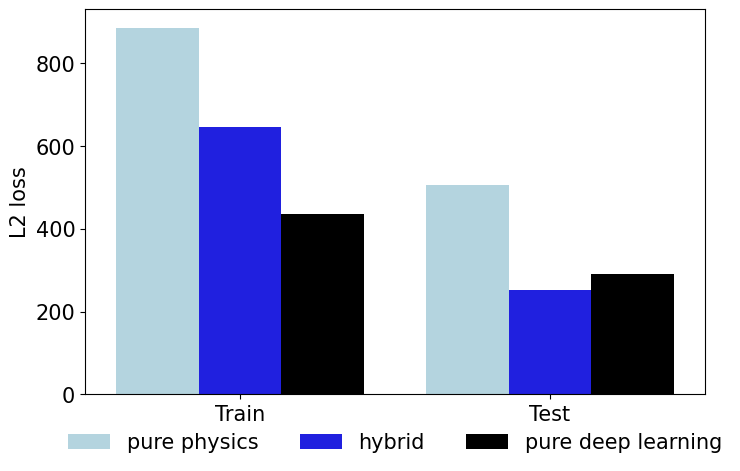

In [17]:
metric = 'mse'
fig, ax = plt.subplots(1,1,figsize=(8,5))
sns.barplot(x="data", y="value", hue="model", ax=ax,
            palette=['lightblue', 'blue', 'black'],
            data=metrics_df[(metrics_df['metric']==metric)])
ax.set(xlabel='', ylabel='L2 loss')
ax.legend(ncol=3, loc="lower center", frameon=False, bbox_to_anchor=(0.5, -.2), prop={'size': 15})


# Plot

## LE

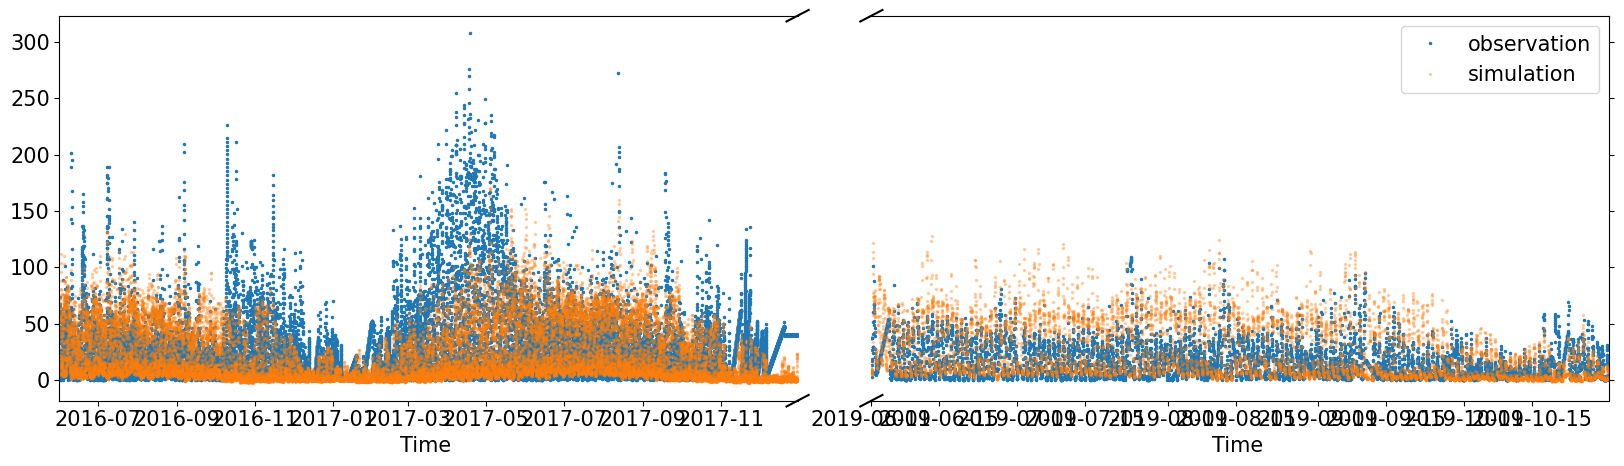

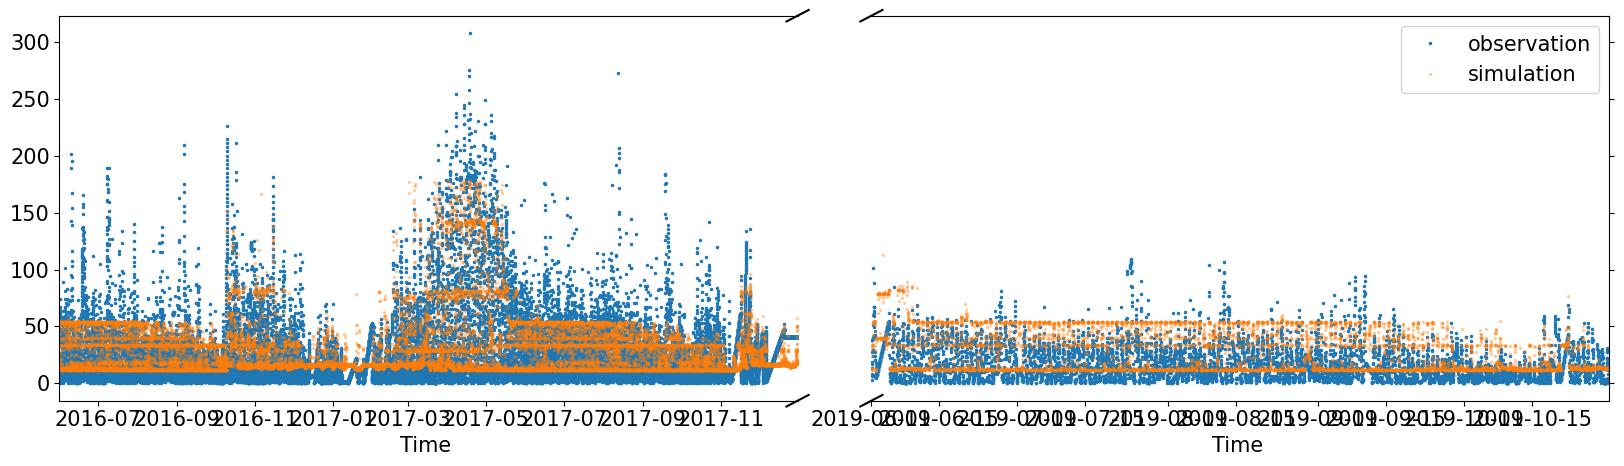

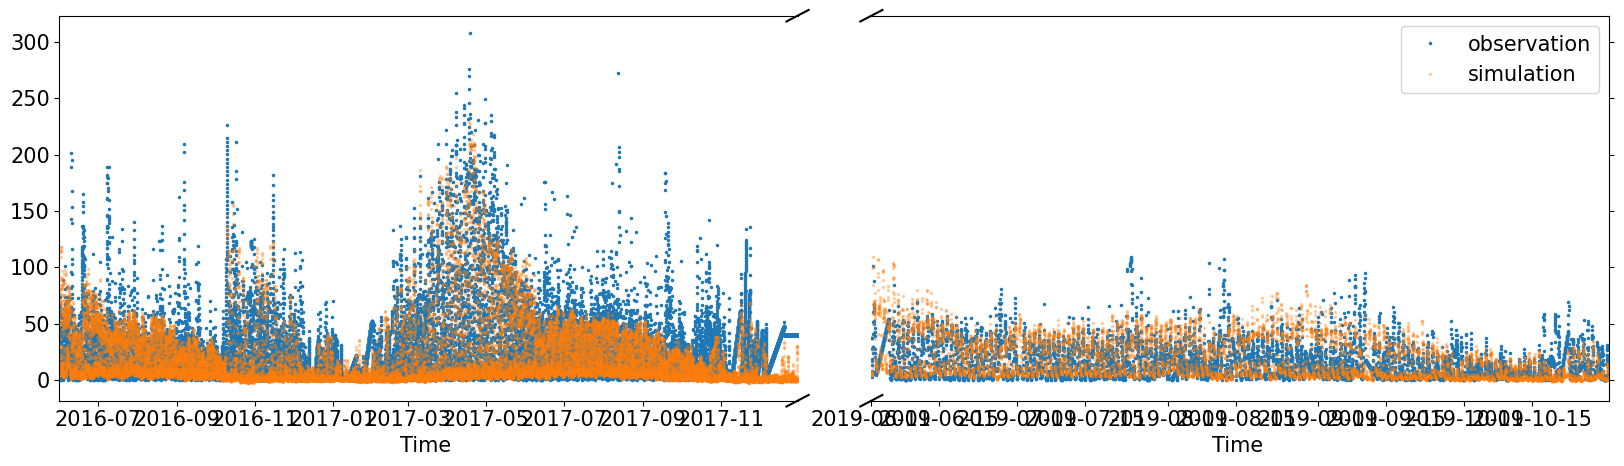

In [91]:
for out in [out1, out2, out3]:
    try:
        can_LE_train = out['train']['can.LE']
        can_LE_test  = out['test']['can.LE']
    except:
        can_LE_train = out['train']['LE']
        can_LE_test  = out['test']['LE']
    can_LE = jnp.concatenate([can_LE_train, can_LE_test])
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(20, 5), facecolor='w')
    
    # Train
    plot_timeseries(
        obs.LE,
        timesteps=timesteps,
        ax=ax1,
        title=None,
        label="observation",
        alpha=1.0,
        tunit="",
        linestyle='.',
    )
    plot_timeseries(
        can_LE_train,
        timesteps=timesteps,
        ax=ax1,
        title=None,
        label="simulation",
        alpha=0.3,
        tunit="",
        linestyle='.',
    )
    
    # Test
    plot_timeseries(
        obs_test.LE,
        timesteps=timesteps_test,
        ax=ax2,
        title=None,
        label="observation",
        alpha=1.0,
        tunit="",
        linestyle='.',
    )
    plot_timeseries(
        can_LE_test,
        timesteps=timesteps_test,
        ax=ax2,
        title=None,
        label="simulation",
        alpha=0.3,
        tunit="",
        linestyle='.',
    )
    
    # hide the spines between ax1 and ax2
    ax1.spines.right.set_visible(False)
    ax2.spines.left.set_visible(False)
    ax1.yaxis.tick_left()
    ax2.yaxis.tick_right()
    
    d = .015  # how big to make the diagonal lines in axes coordinates
    # arguments to pass plot, just so we don't keep repeating them
    kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
    ax1.plot((1-d, 1+d), (-d, +d), **kwargs)
    ax1.plot((1-d, 1+d), (1-d, 1+d), **kwargs)

    kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
    ax2.plot((-d, +d), (1-d, 1+d), **kwargs)
    ax2.plot((-d, +d), (-d, +d), **kwargs)
    
    ax2.legend()
    
    plt.subplots_adjust(wspace=0.1)


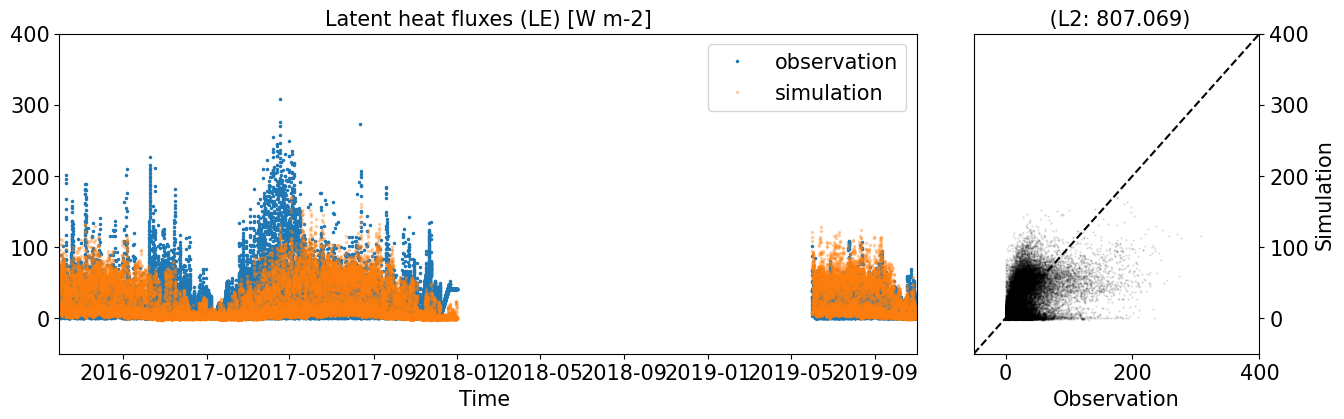

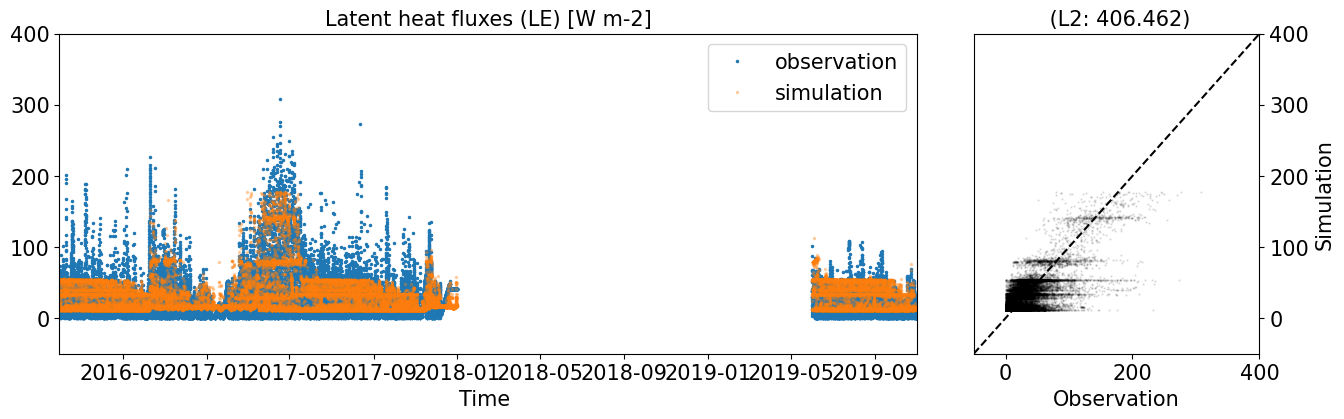

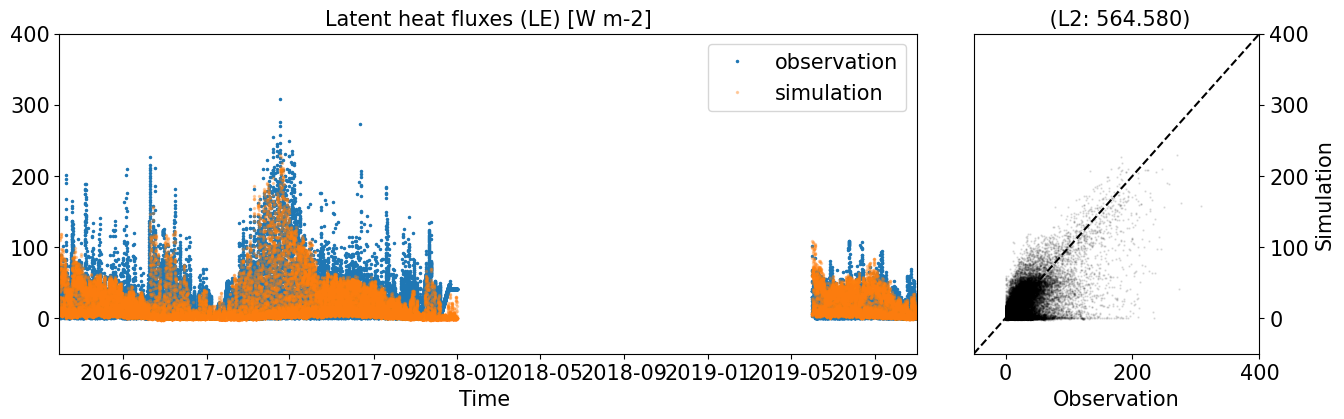

In [52]:
for out in [out1, out2, out3]:
    try:
        can_LE_train = out['train']['can.LE']
        can_LE_test  = out['test']['can.LE']
    except:
        can_LE_train = out['train']['LE']
        can_LE_test  = out['test']['LE']
    can_LE = jnp.concatenate([can_LE_train, can_LE_test])
    fig, ax1, ax2 = plot_timeseries_obs_1to1(
        obs_all.LE,
        can_LE,
        lim=[-50, 400],
        met=met_all,
        varn="Latent heat fluxes (LE) [W m-2]",
        linestyle=".",
    )


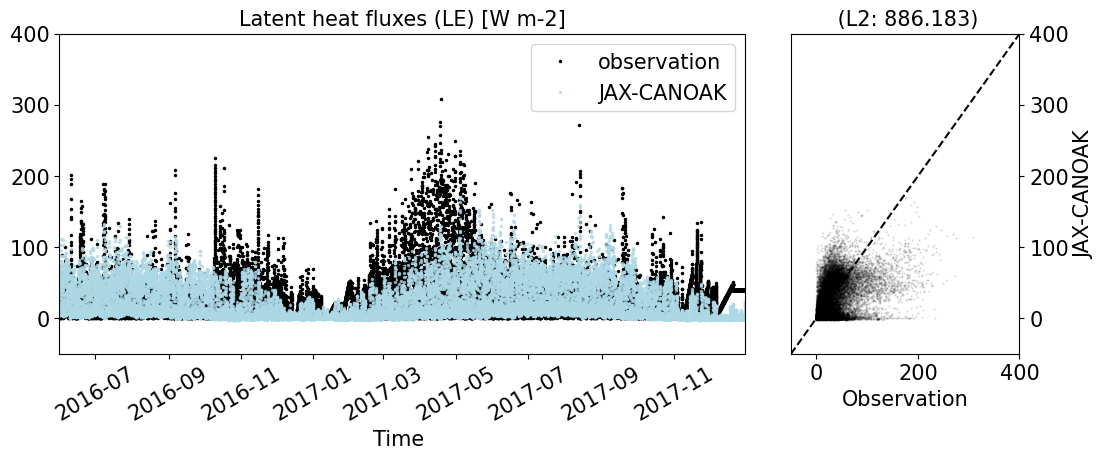

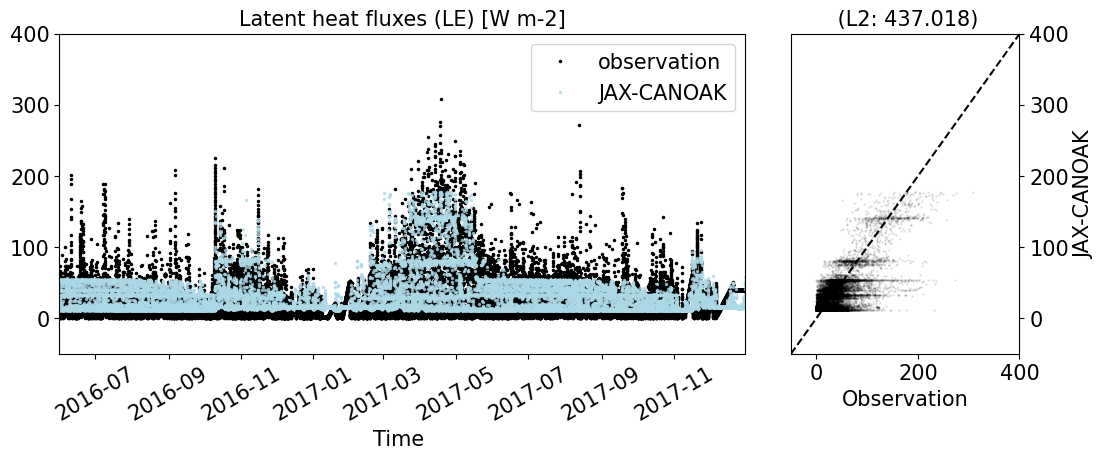

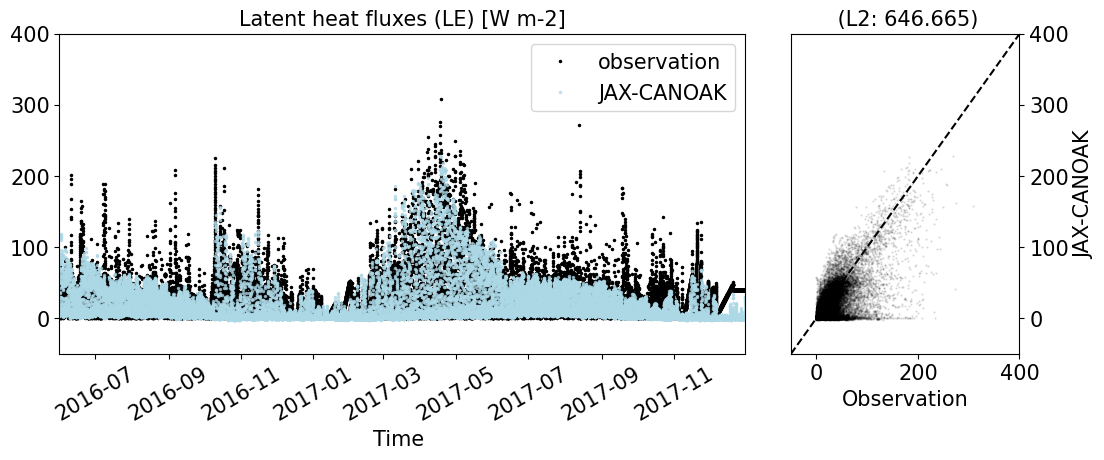

In [24]:
for out in [out1, out2, out3]:
    try:
        can_LE = out['train']['can.LE']
    except:
        can_LE = out['train']['LE']
    fig, ax1, ax2 = plot_timeseries_obs_1to1(
        obs.LE,
        can_LE,
        lim=[-50, 400],
        met=met,
        varn="Latent heat fluxes (LE) [W m-2]",
        linestyle=".",
    )
    ax1.tick_params(axis='x', rotation=30);


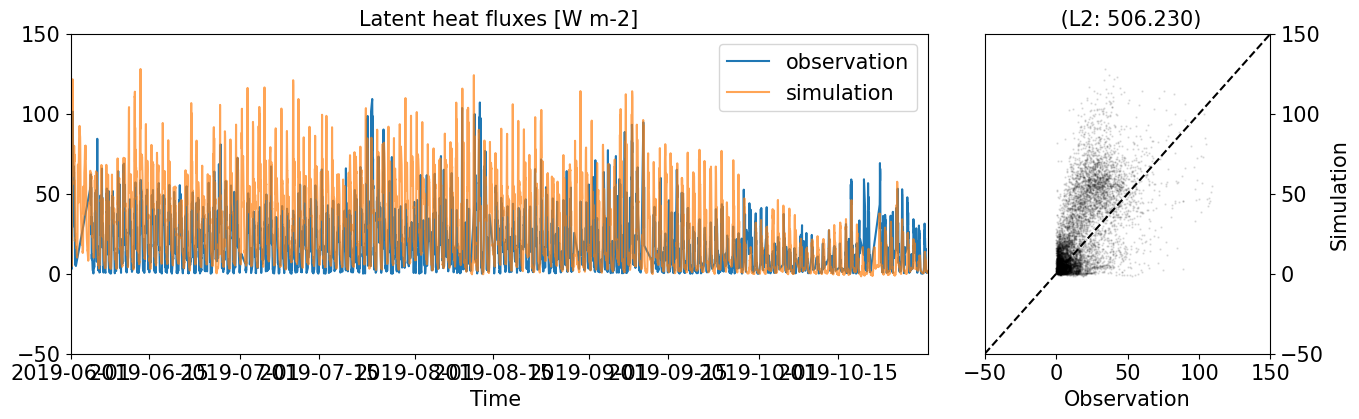

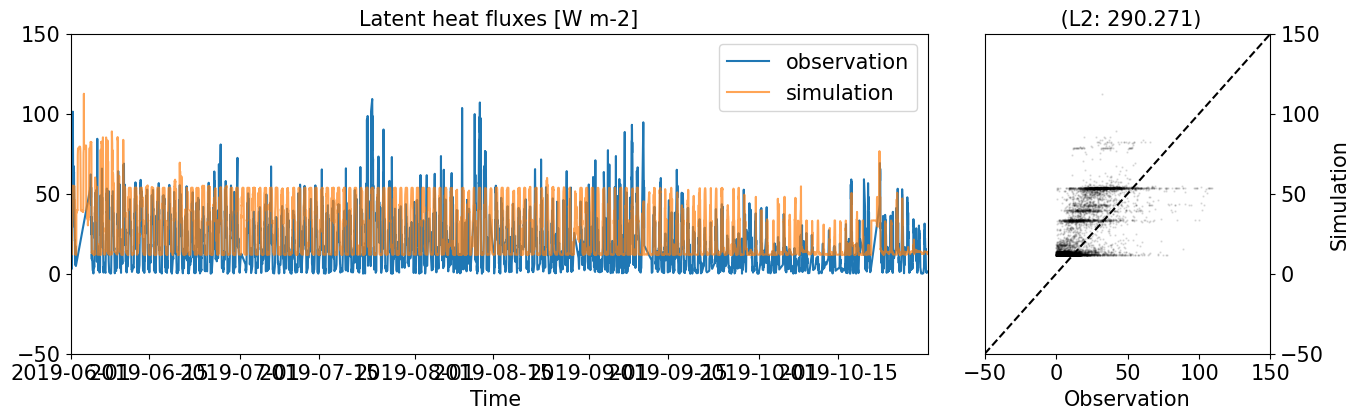

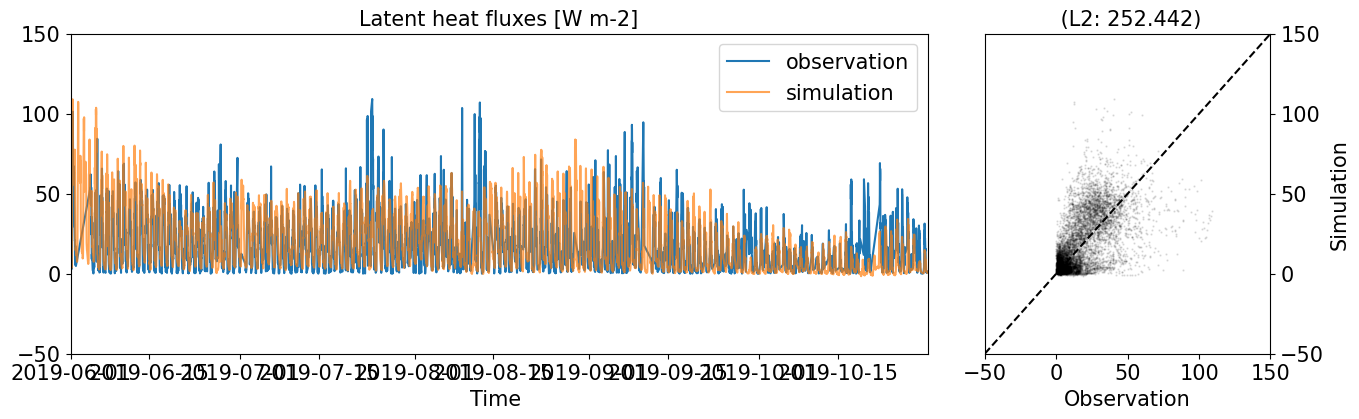

In [94]:
for out in [out1, out2, out3]:
    try:
        can_LE = out['test']['can.LE']
    except:
        can_LE = out['test']['LE']
    fig, ax1, ax2 = plot_timeseries_obs_1to1(
        obs_test.LE,
        can_LE,
        lim=[-50, 150],
        met=met_test,
        varn="Latent heat fluxes [W m-2]",
        # linestyle=".",
    )


## Stomatal conductance

In [ ]:
for out in [out1, out3]:
    can = out['train']['sun.gs'].T
    plot_imshow2b(
        can,
        met,
        para.zht1,
        key="swc",
        title="Sunlit leaf stomatal conductance [m/s]",
        cmap="Blues",
        vmax=0.002
    )


/global/homes/p/peishi89/jax-watershed/src/jax_canoak/shared_utilities/plot.py:244: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax1.get_xticklabels(), rotation=15, ha="right")
/global/homes/p/peishi89/jax-watershed/src/jax_canoak/shared_utilities/plot.py:244: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax1.get_xticklabels(), rotation=15, ha="right")


/global/homes/p/peishi89/jax-watershed/src/jax_canoak/shared_utilities/plot.py:119: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.plot(array.mean(axis=1), verticals)
/global/homes/p/peishi89/jax-watershed/src/jax_canoak/shared_utilities/plot.py:119: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.plot(array.mean(axis=1), verticals)


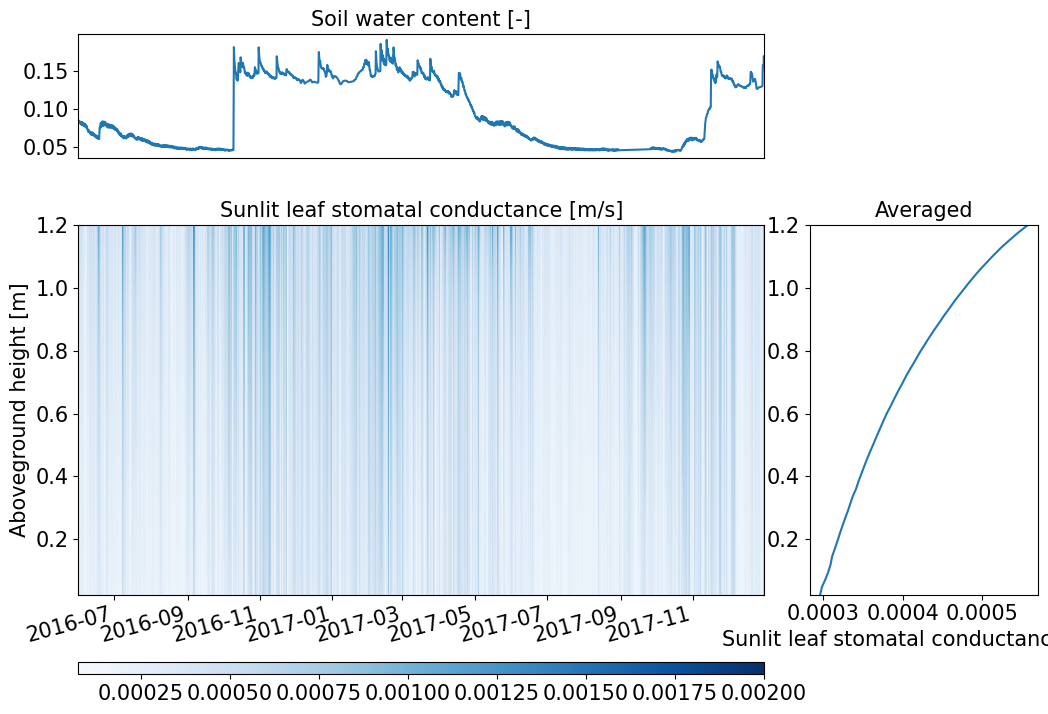

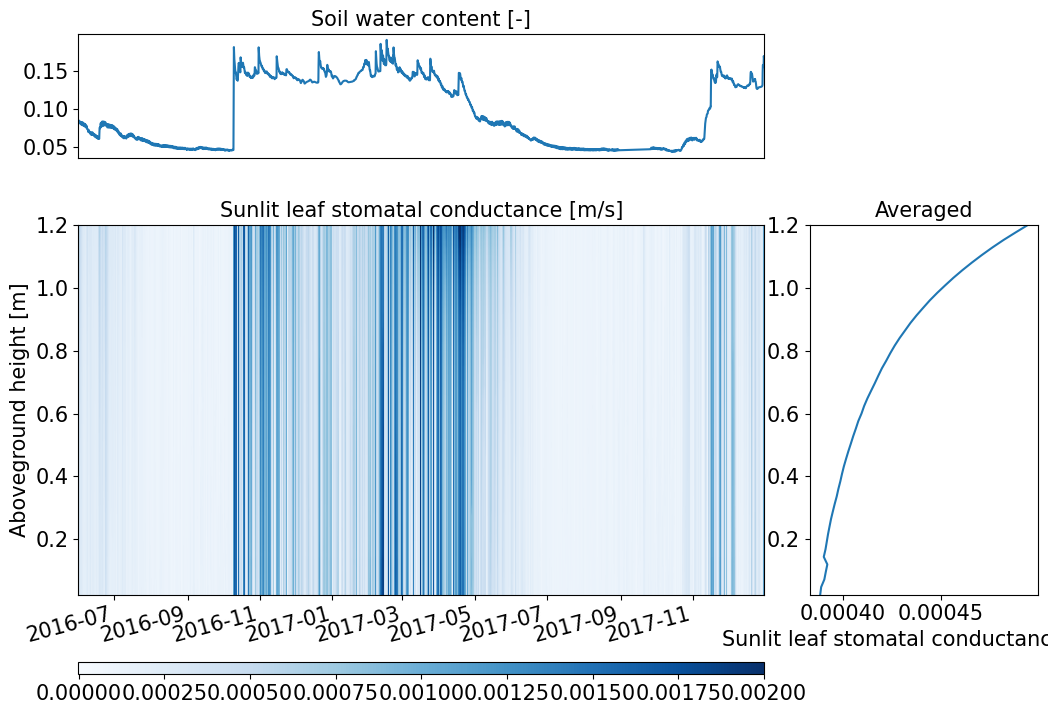

In [73]:
for out in [out1, out3]:
    can = out['train']['sun.gs'].T
    plot_imshow2(
        can,
        met,
        para.zht1,
        key="swc",
        title="Sunlit leaf stomatal conductance [m/s]",
        cmap="Blues",
        vmax=0.002
    )


/global/homes/p/peishi89/jax-watershed/src/jax_canoak/shared_utilities/plot.py:115: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=15, ha="right")
/global/homes/p/peishi89/jax-watershed/src/jax_canoak/shared_utilities/plot.py:115: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=15, ha="right")


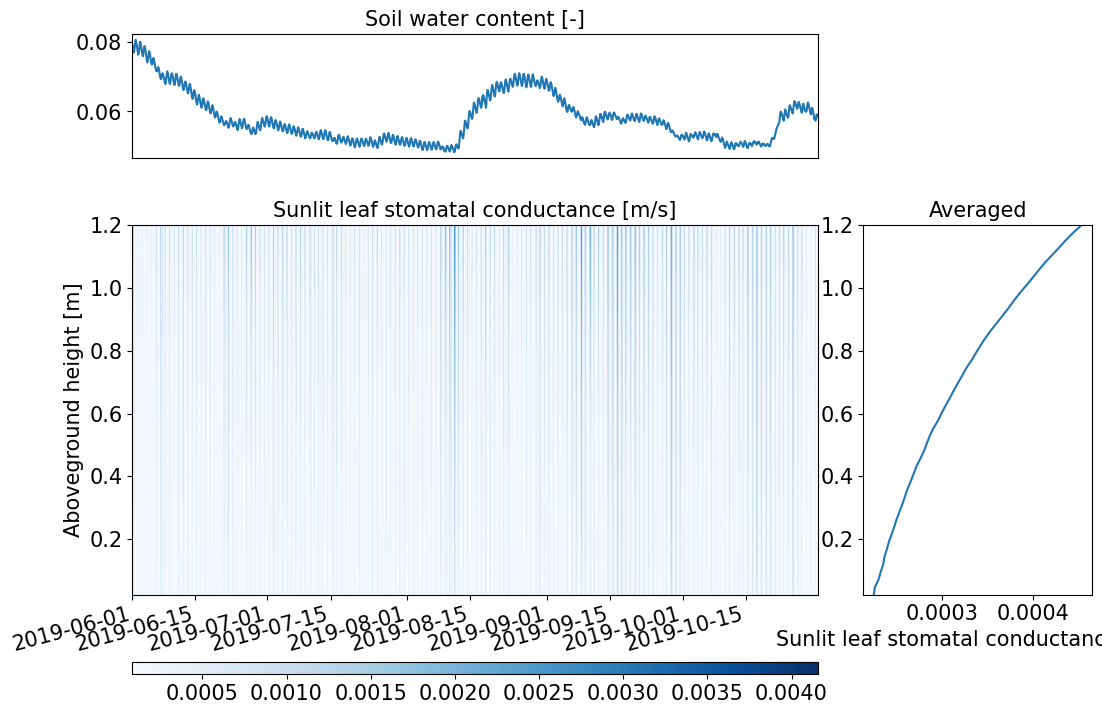

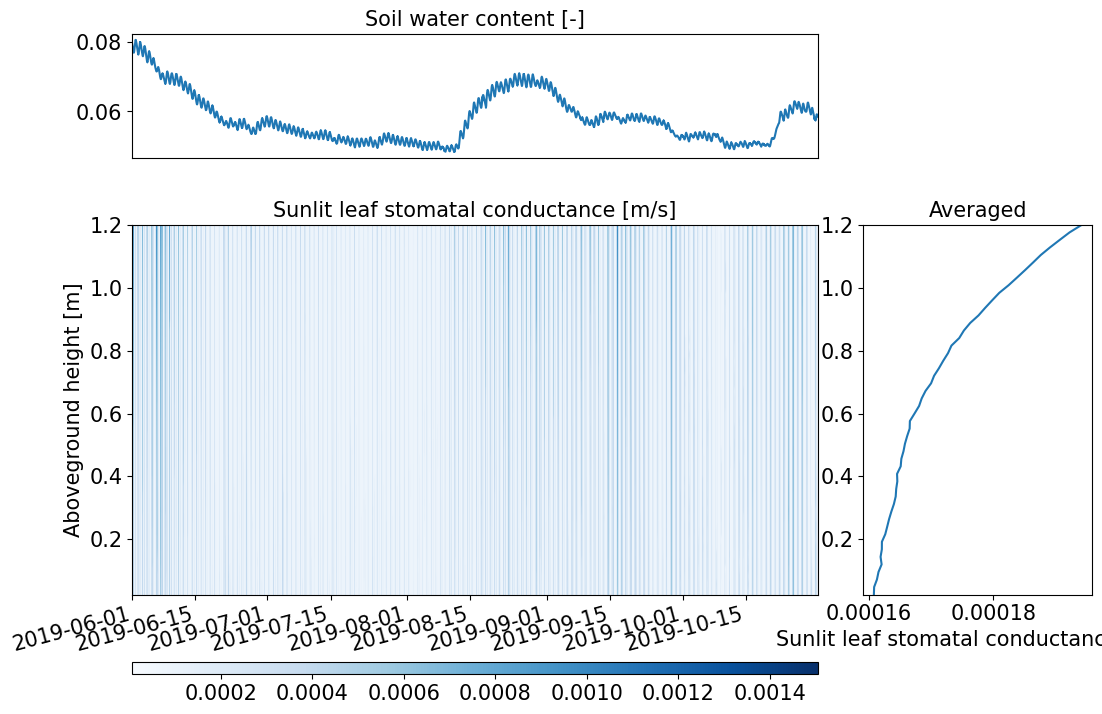

In [72]:
for out in [out1, out3]:
    can = out['test']['sun.gs'].T
    plot_imshow2(
        can,
        met_test,
        para.zht1,
        key="swc",
        title="Sunlit leaf stomatal conductance [m/s]",
        cmap="Blues",
    )


## Leaf relative humidity

/global/homes/p/peishi89/jax-watershed/src/jax_canoak/shared_utilities/plot.py:115: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=15, ha="right")
/global/homes/p/peishi89/jax-watershed/src/jax_canoak/shared_utilities/plot.py:115: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=15, ha="right")


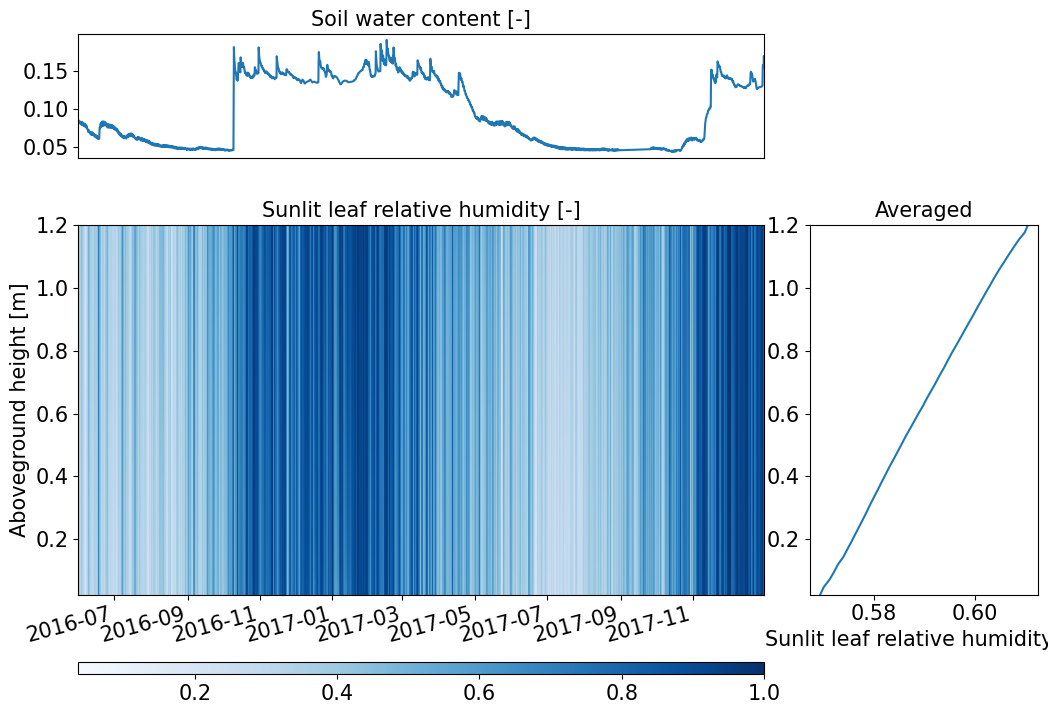

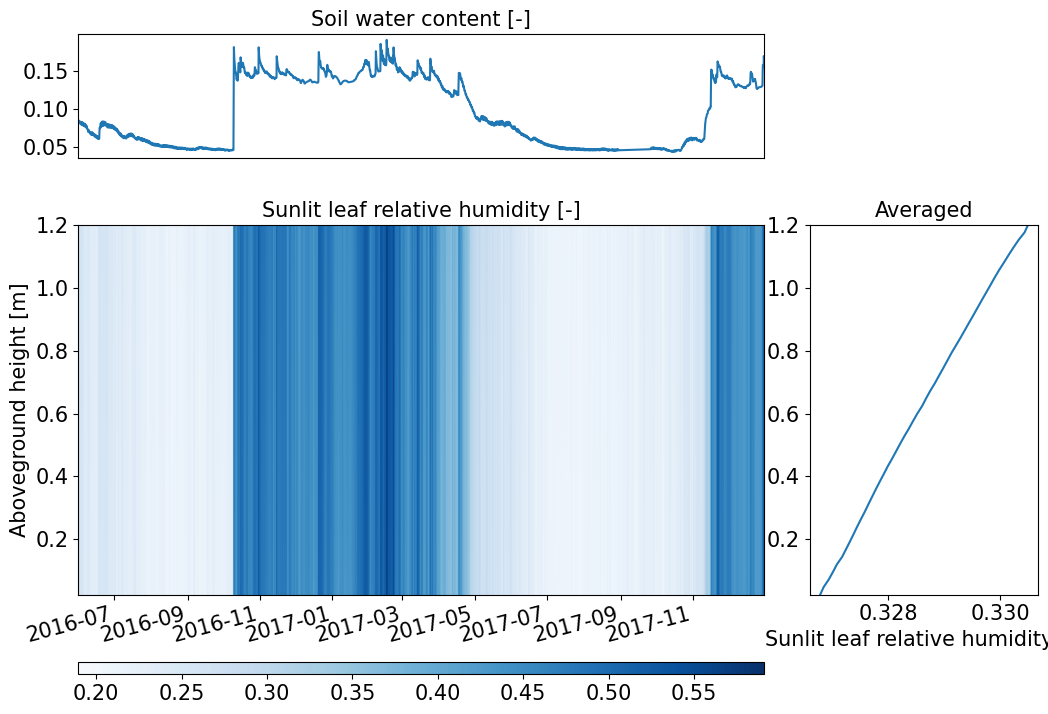

In [31]:
for out in [out1, out3]:
    can = out['train']['sun.Leaf_RH'].T
    plot_imshow2(
        can,
        met,
        para.zht1,
        key="swc",
        title="Sunlit leaf relative humidity [-]",
        cmap="Blues",
    )


/global/homes/p/peishi89/jax-watershed/src/jax_canoak/shared_utilities/plot.py:115: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=15, ha="right")
/global/homes/p/peishi89/jax-watershed/src/jax_canoak/shared_utilities/plot.py:115: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=15, ha="right")


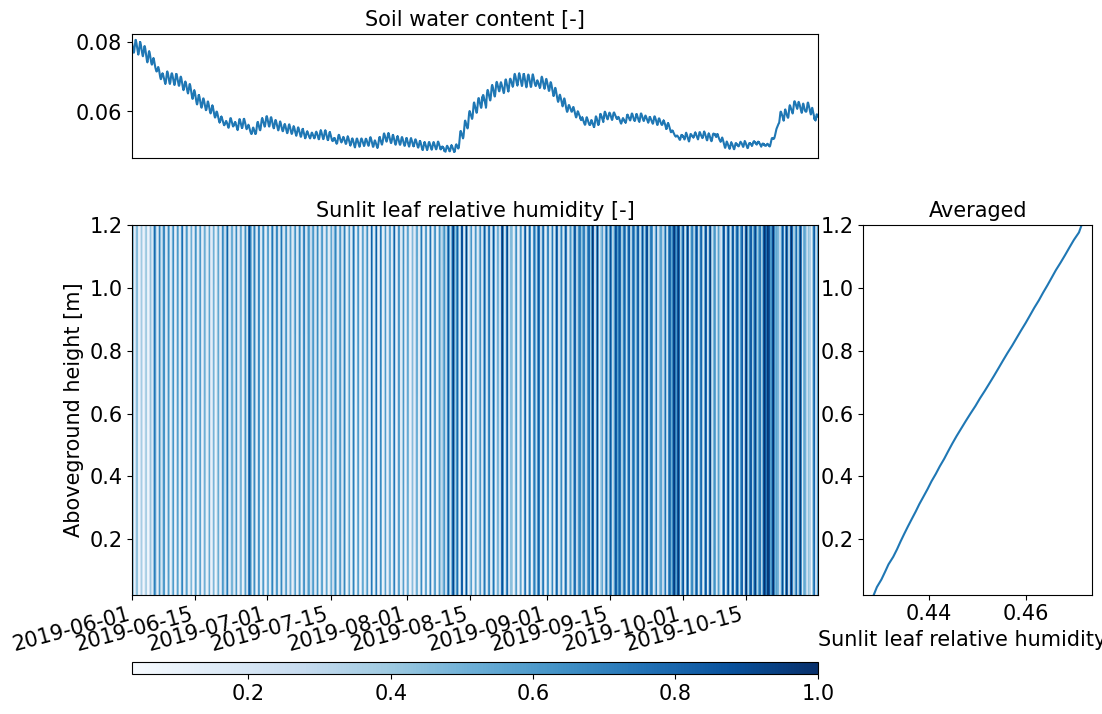

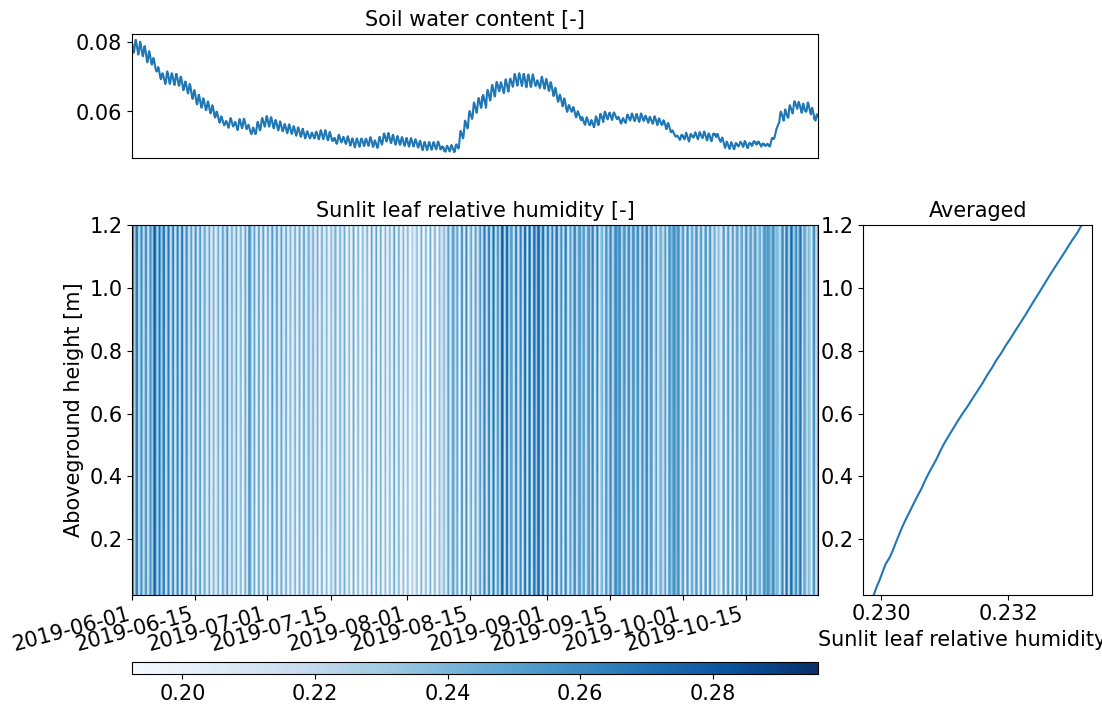

In [32]:
for out in [out1, out3]:
    can = out['test']['sun.Leaf_RH'].T
    plot_imshow2(
        can,
        met_test,
        para.zht1,
        key="swc",
        title="Sunlit leaf relative humidity [-]",
        cmap="Blues",
    )
